# Download Dataset

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2025-05-06 09:30:45.812327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746523845.834515    6048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746523845.841231    6048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
import os
import glob
import string
import dlib
from typing import List

In [3]:
 #!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

In [4]:
# Initialize dlib face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



# Indexes for mouth landmarks (according to the 68 points dlib model)
MOUTH_POINTS = list(range(48, 61))

In [5]:
def clip_mouth(frame):
    # Convert frame to grayscale for dlib processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect faces in the frame
    faces = detector(gray)
    if len(faces) == 0:
        return None  # If no face is detected, return None
    # Process the first face detected
    face = faces[0]
    landmarks = predictor(gray, face)

    # Get the coordinates of the mouth landmarks
    mouth_points = []
    for i in MOUTH_POINTS:
        x = landmarks.part(i).x
        y = landmarks.part(i).y
        mouth_points.append((x, y))



    # Calculate the bounding box around the lips
    x_coords = [pt[0] for pt in mouth_points]
    y_coords = [pt[1] for pt in mouth_points]
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)



    # Add some padding around the mouth
    padding = 30
    min_x = max(0, min_x - padding)
    max_x = min(frame.shape[1], max_x + padding)
    min_y = max(0, min_y - padding)
    max_y = min(frame.shape[0], max_y + padding)



    # Crop the mouth region from the frame
    mouth_region = frame[min_y:max_y, min_x:max_x]



    return mouth_region

In [6]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []



    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break



        # Clip the mouth region from the video
        mouth_region = clip_mouth(frame)
        if mouth_region is not None:
            # Resize the clipped mouth region to a fixed size, e.g., 128x64
            mouth_region = cv2.resize(mouth_region, (140, 46), interpolation=cv2.INTER_AREA)
            mouth_region = cv2.cvtColor(mouth_region, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            mouth_region = tf.expand_dims(mouth_region, axis=-1)  # Add channel dimension (height, width, 1)
            frames.append(mouth_region)



    cap.release()
    frames_tensor = tf.stack(frames)  # Shape: (num_frames, height, width, 1)

    # Normalize the frames
    mean = tf.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(tf.cast(frames_tensor, tf.float32))
    return tf.cast((frames_tensor - mean), tf.float32) / std

## Data loading

In [7]:
frames = load_video("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s10_processed/bbab8n.mpg")

print(frames.shape)

I0000 00:00:1746523850.485428    6048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746523850.486085    6048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


(75, 46, 140, 1)


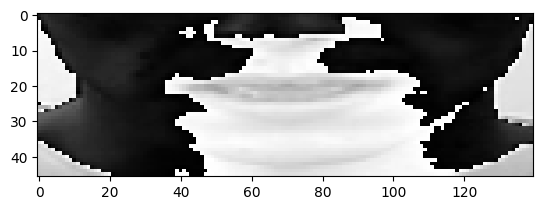

In [8]:
plt.imshow(frames[8],cmap='gray')

#### This lookup table will be used to encode and decoded the characters in labels. This should be consistent over each and every run

In [9]:
vocab = string.ascii_lowercase + "'?! "

vocab = list(vocab)

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [11]:
char2num_dict = {c: char_to_num(c).numpy() for c in char_to_num.get_vocabulary()}

char2num_dict

{'': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27,
 '?': 28,
 '!': 29,
 ' ': 30}

In [12]:
num2char_dict = {char_to_num(c).numpy():c  for c in num_to_char.get_vocabulary()}

num2char_dict

{0: '',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: "'",
 28: '?',
 29: '!',
 30: ' '}

In [13]:
print(char_to_num(["a", "b", "c"]),

     num_to_char([1,2,3]))

tf.Tensor([1 2 3], shape=(3,), dtype=int64) tf.Tensor([b'a' b'b' b'c'], shape=(3,), dtype=string)


### Specification of Loading Alignments and Preprocessing
* Step 1. Read the text file

* Step 2. Get the text for each word

* Step 3. Create a tensor of numbers from LookUp Table

In [14]:
def load_alignment(path : str):
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        start, end, text = line.split()
        if text!='sil':
            tokens.append(text)

    chars = list(" ".join(tokens))
    return char_to_num(chars)

In [15]:
num = load_alignment("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s10_processed/align/bbab8n.align")

print(num)

print(num_to_char(num))

tf.Tensor([ 2  9 14 30  2 12 21  5 30  1 20 30  2 30  5  9  7  8 20 30 14 15 23], shape=(23,), dtype=int64)
tf.Tensor(
[b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'b' b' '
 b'e' b'i' b'g' b'h' b't' b' ' b'n' b'o' b'w'], shape=(23,), dtype=string)


## Combined Loading Function to Load Video and Alignments at once

In [16]:
def load_data(video_path : str):
    video_id = video_path.numpy().decode('UTF-8').replace("\\", "/").split("/")[-1].split(".")[0]
    folder_id = video_path.numpy().decode('UTF-8').replace("\\", "/").split("/")[-2].split("_")[0]
    align_path = f"/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/{folder_id}_processed/align/{video_id}.align"
    video_path = video_path.numpy().decode('UTF-8')
    video_data = load_video(video_path)
    char_num = load_alignment(align_path)
    return video_data, char_num

In [17]:
v,c = load_data(tf.constant("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/bbaf2n.mpg"))

In [18]:
v.shape, c.shape

(TensorShape([75, 46, 140, 1]), TensorShape([21]))

In [19]:
def mappable_function(path: str):
    try:
        result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    except Exception as e:
        print(f"Error in {path}: {e}")
        result = None
    return result

## Create Data loading function

In [20]:
from sklearn.model_selection import train_test_split

In [21]:

# videos = []
# for id in range(34):
#     cur_vid = glob.glob(f"/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s{id+1}_processed/*.mpg")
#     videos.extend(cur_vid)
id = 1
videos = glob.glob(f"/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s{id}_processed/*.mpg")

print("Number of videos found :", len(videos))

Number of videos found : 1000


In [22]:
train, test = train_test_split(videos, test_size=0.2, random_state=42)

In [23]:
batch_size = 12

data = tf.data.Dataset.from_tensor_slices(train)
data = data.shuffle(500)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
data = data.apply(tf.data.experimental.ignore_errors())
data = data.padded_batch(batch_size, padded_shapes=([75, 46, 140, 1], [40]))
data = data.prefetch(tf.data.AUTOTUNE).cache()
data = data.repeat()


val = tf.data.Dataset.from_tensor_slices(test)
val = val.shuffle(500)
val = val.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)
val = val.apply(tf.data.experimental.ignore_errors())
val = val.padded_batch(batch_size, padded_shapes=([75,  46, 140, 1], [40]))
val = val.prefetch(tf.data.AUTOTUNE).cache()
val = val.repeat()

In [24]:
it = data.as_numpy_iterator()
f, a = it.next()

f.shape, a.shape

((12, 75, 46, 140, 1), (12, 40))

# Build Model

In [25]:
# !nvcc --version
# !cat /usr/include/cudnn_version.h | grep CUDNN
# import tensorflow as tf
# print(tf.__version__)

In [26]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import (Conv3D, Dense,GRU, LSTM, Bidirectional, Dropout, 

                                     MaxPool3D, Activation, Reshape, SpatialDropout3D, 

                                     BatchNormalization, TimeDistributed, Flatten, Input)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import layers, models

In [27]:
@tf.keras.utils.register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_size = tf.cast(tf.shape(y_true)[0], tf.int64)
    input_len = tf.cast(tf.shape(y_pred)[1], tf.int64)
    label_len = tf.cast(tf.shape(y_true)[1], tf.int64)


    input_len = input_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    label_len = label_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)

    # deprecated, need to find the new method now
    return loss


In [28]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

In [29]:
# with strategy.scope():

#     model = Sequential()
    
#     model.add(Input(shape=(75, 46, 140, 1)))
    
#     model.add(Conv3D(128, kernel_size=3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))
#     model.add(Conv3D(256, kernel_size=3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))
#     model.add(Conv3D(64, kernel_size=3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPool3D(pool_size=(1,2,2)))
    
#     model.add(Reshape([75, 5440]))

#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))
#     model.add(Bidirectional(LSTM(256, return_sequences=True)))
#     model.add(Dropout(0.5))

#     model.add(Dense(512, kernel_initializer='he_normal'))
#     model.add(Activation('relu'))
#     model.add(Dense(512, kernel_initializer='he_normal'))
#     model.add(Activation('relu'))
    
#     model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax', kernel_initializer='he_normal'))

#     model.summary()
#     model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

In [30]:
with strategy.scope():
    
    model = Sequential()
    
    model.add(Input(shape=(75, 46, 140, 1)))  # (frames, height, width, channels)
    
    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))  
    
    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2))) 
    

    model.add(Conv3D(256, (3,3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2))) # spatial reduction
    
    # Reshape for GRU 
    model.add(Reshape((-1, 256*5*17)))
    
    # GRU Layers (Bidirectional)
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(Dropout(0.3))
    
    # Output
    model.add(Dense(512, activation='relu'))
    model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax'))
    model.summary()
    model.compile(optimizer=Adam(0.0001), loss=CTCLoss)
    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 75, 46, 140, 64)     │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 46, 140, 64)     │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 75, 46, 140, 64)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 75, 23, 70, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 75, 23, 70, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 23, 70, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 75, 11, 35, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 75, 11, 35, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 75, 11, 35, 256)     │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 75, 5, 17, 256)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 75, 21760)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 75, 512)             │      33,819,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 75, 512)             │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 75, 512)             │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75, 32)              │          16,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,391,328 (138.82 MB)

 Trainable params: 36,390,432 (138.82 MB)

 Non-trainable params: 896 (3.50 KB)

In [31]:
# def schedular(epoch, lr):
#     if epoch<100:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

In [32]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        self.it = self.dataset.as_numpy_iterator()



    def on_epoch_end(self, epoch, logs=None) -> None:
        print(f'epoch:{epoch+1} has ended')
        data = self.it.next()
        if data[0].shape[0] < 8:
            self.it = self.dataset.as_numpy_iterator()
            data = self.it.next()
        yhat = model.predict(data[0], verbose=0)
        decoded = tf.keras.backend.ctc_decode(yhat, [75]*data[0].shape[0], greedy=True)[0][0].numpy()  # Adjust length to match
        for x in range(min(5, len(decoded))):  # Limit to available predictions
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [33]:
callbacks = [

    # Save the model in .keras format
    ModelCheckpoint("model_val_loss.keras", monitor="val_loss", save_best_only=True, verbose=1),
    ModelCheckpoint("model_loss.keras", monitor="loss", save_best_only=True, verbose=1),



    # Save only the weights
    ModelCheckpoint("model_val_loss_weights.weights.h5", monitor="val_loss", save_best_only=True, verbose=1, save_weights_only=True),
    ModelCheckpoint("model_loss_weights.weights.h5", monitor="loss", save_best_only=True, verbose=1, save_weights_only=True),



    # Custom callback (assuming ProduceExample is properly defined)
    ProduceExample(val),
    ProduceExample(data)

]

In [34]:
print(model.output_shape)

(None, 75, 32)


In [35]:
for batch in data.take(1):
    print("X shape:", batch[0].shape)
    print("Y shape:", batch[1].shape)
    print("Y dtype:", batch[1].dtype)

X shape: (12, 75, 46, 140, 1)
Y shape: (12, 40)
Y dtype: <dtype: 'int64'>


In [36]:
# from keras.models import load_model

In [37]:
# model = load_model("/kaggle/working/model_loss.keras", custom_objects={'CTCLoss': CTCLoss})

In [ ]:
history=model.fit(data, epochs=50, validation_data=(val), callbacks=callbacks, verbose=2)

Epoch 1/50


I0000 00:00:1746523911.462168    6105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746523911.476177    6106 cuda_dnn.cc:529] Loaded cuDNN version 90300
[mpeg1video @ 0x56996800] ac-tex damaged at 22 17
[mpeg1video @ 0x56996800] Warning MVs not available


In [ ]:
import json
import os
from datetime import datetime

def save_history(new_history, filepath='training_history.json', start_epoch=0):
    new_data = new_history.history
    n_epochs = len(next(iter(new_data.values())))  # Number of epochs in this run

    # Add epoch numbers and timestamped runs
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    run_entry = {
        'timestamp': timestamp,
        'epochs': []
    }

    for i in range(n_epochs):
        epoch_entry = {'epoch': start_epoch + i}
        for key in new_data:
            epoch_entry[key] = new_data[key][i]
        run_entry['epochs'].append(epoch_entry)

    # Load existing data if exists
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            all_runs = json.load(f)
    else:
        all_runs = []

    all_runs.append(run_entry)

    # Save all runs
    with open(filepath, 'w') as f:
        json.dump(all_runs, f, indent=4)


In [ ]:
start_epoch = 0
save_history(new_history = history,start_epoch = start_epoch)